# A Newbie's Attempt to do Error Analysis 🤓

In this notebook, we'll be attempting to gain insights on the performance of a trained LSTM model by carrying out the following analysis:

* Evaluate error metrics on the train and test data.
* Plot confusion matrix on the test data.
* Analyse errors by inspecting samples that the model misclassfied.

## Import

In [1]:
import torch
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from transformers import AutoTokenizer
from src.model.lstm import LSTMClassifier
from src.agnews_dataset import preprocess_data, AGNewsDataset

## Load Model

The model I will be analysing is a bidirectional LSTM model trained on the [AGNews Classification dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset).

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "model/lstm_2023-12-02_18-07-51.pt"
model_ckpt = torch.load(ckpt_path, map_location=device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = LSTMClassifier(
    vocab_size=len(tokenizer),
    embedding_dim=model_ckpt["model_args"]["embedding_dim"],
    hidden_dim=model_ckpt["model_args"]["hidden_dim"],
    num_layers=model_ckpt["model_args"]["num_layers"],
    output_dim=model_ckpt["model_args"]["output_dim"],
    dropout=model_ckpt["model_args"]["dropout"],
).to(device)
model.load_state_dict(model_ckpt["state_dict"])

model

LSTMClassifier(
  (embedding): Embedding(30522, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

## Load Dataset

In [4]:
train_data_path = "data/train.csv"

# Split data into train and validation set, and discard the validation set for now, we will be using a standalone test set instead.
train_text, train_label = preprocess_data(data_path=train_data_path)
train_text, _, train_label, _ = train_test_split(
    train_text,
    train_label,
    test_size=0.2,
    random_state=model_ckpt["model_args"]["seed"],
)

train_encoding = tokenizer(
    train_text,
    truncation=True,
    padding=True,
    max_length=model_ckpt["model_args"]["max_length"],
)
train_dataset = AGNewsDataset(train_encoding, train_label)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

print(len(train_dataset))

96000


In [5]:
test_data_path = "data/test.csv"
test_text, test_label = preprocess_data(data_path=test_data_path)
test_encoding = tokenizer(
    test_text,
    truncation=True,
    padding=True,
    max_length=model_ckpt["model_args"]["max_length"],
)
test_dataset = AGNewsDataset(test_encoding, test_label)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

print(len(test_dataset))

7600


## Inference

In [6]:
model.eval()

train_preds = []
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        output = model(batch["input_ids"])
        pred = torch.argmax(output, dim=1)
        train_preds.extend(pred.cpu().numpy())

test_preds = []
misclass_df = pd.DataFrame(columns=["text", "label", "pred"])
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        output = model(batch["input_ids"])
        pred = torch.argmax(output, dim=1)
        test_preds.extend(pred.cpu().numpy())

        # Misclassified samples
        misclass_idx = torch.where(pred != batch["labels"])[0]
        misclass_text = [
            tokenizer.convert_tokens_to_string(
                tokenizer.convert_ids_to_tokens(  # type: ignore
                    batch["input_ids"][idx].cpu().numpy(), skip_special_tokens=True
                )
            )
            for idx in misclass_idx
        ]
        misclass_label = [batch["labels"][idx].item() for idx in misclass_idx]
        misclass_df = pd.concat(
            [
                misclass_df,
                pd.DataFrame(
                    {
                        "text": misclass_text,
                        "label": misclass_label,
                        "pred": pred[misclass_idx].cpu().numpy(),
                    }
                ),
            ]
        )

## Error Metrics

In [7]:
target_names = ["World", "Sports", "Business", "Sci/Tech"]
print(classification_report(train_label, train_preds, target_names=target_names))

              precision    recall  f1-score   support

       World       0.97      0.91      0.94     23967
      Sports       0.97      0.99      0.98     23968
    Business       0.92      0.92      0.92     24046
    Sci/Tech       0.91      0.94      0.92     24019

    accuracy                           0.94     96000
   macro avg       0.94      0.94      0.94     96000
weighted avg       0.94      0.94      0.94     96000



In [8]:
print(classification_report(test_label, test_preds, target_names=target_names))

              precision    recall  f1-score   support

       World       0.94      0.88      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.87      0.90      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



From the classificiation reports above we can observe, that the model performs best on the Sports genre, second on the World genre, while having relative lower performance on the Business and Sci/Tech genre.

Since the data is fairly balanced, this variance in performance could be attribute to the inherent characteristics of each genre.

For example, the Sports article usually possess unique and easily identifiable features, while the Business and Sci/Tech article often shares similar themes and terminologies.

Such similarity might leads to a higher likelihood of misclassification by the model.

## Confusion Matrix

To gain deeper insight into the model's misclassifications across each class, we will plot a confusion matrix on the test data.

This visual representation will help us better understand where the model tends to confuse one category for another

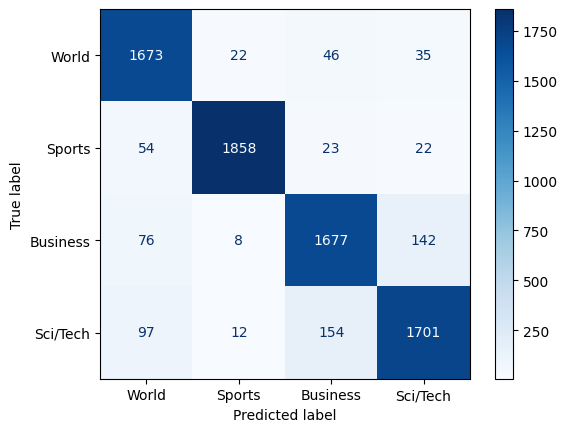

In [9]:
ConfusionMatrixDisplay.from_predictions(
    test_preds, test_label, display_labels=target_names, cmap="Blues"
)

The confusion matrix clearly indicates that the model is significantly more prone to misclassification when distinguishing between Business and Sci/Tech articles, with a likelihood more than three times higher compared to other categories. 

## Sample Inspection

Let's delve a little deeper into these two genres. More specificlly, we'll randomly sample 5 Business articles that the model misclassified as Sci/Tech article, and 5 vice versa.

Hopefully we can identify similar theme and terminologies amongst these articles, to gain insights on why the model misclassified them.

In [10]:
# Sample 5 Business article misclassified as Sci/Tech
for text in misclass_df[
    (misclass_df["label"] == 2) & (misclass_df["pred"] == 3)
].sample(5, random_state=0)["text"]:
    print(text)

microsoft vs sendo : it # 39 ; s overthe legal battle between uk phone manufacturer sendo and microsoft has been settled, the companies announced on monday morning. sendo had been suing microsoft for the alleged theft of trade secrets, fraud
microsoft readies next business im servera little over a year after introducing the first version of office live communications server, microsoft says it plans to release the next version of its enterprise instant messaging software, in december.
i. b. m. sought a china partnership, not just a saleinside i. b. m., the issue of whether to stay in the personal computer business has been debated for a decade. the issue was put to rest last week.
halo 2 scores record sales of \ $ 125 million in first 24 hourshalo 2 broke entertainment retail records in its first 24 hours. microsoft game studios said that the video game sold through 2. 4 million stores in the us and canada raking in \ $ 125 million in sales.
storms seem to cure floridians of hurricane a

In [11]:
# Sample 5 Sci/Tech article misclassified as Business
for text in misclass_df[
    (misclass_df["label"] == 3) & (misclass_df["pred"] == 2)
].sample(5, random_state=0)["text"]:
    print(text)

a # 39 ; plan b # 39 ; for peoplesoft customerscom september 20, 2004, 6 : 13 pm pt. this fourth priority # 39 ; s main focus has been improving or obtaining crm and erp software for the past year and a half.
fujitsu siemens profit grows 60 percentfujitsu siemens computers ( holding ) bv, europe # 39 ; s largest remaining computer manufacturer, posted a 60 percent leap in profit for the first half of its fiscal year on higher sales of laptops and servers to business customers, the company said wednesday.
our mobile margins will fall : telstratelstra chief financial officer john stanhope has admitted telstra # 39 ; s margins in its \ $ 4. 5 billion a year mobile phone business will shrink this year in the face of increased price competition and the growing cost of acquiring new customers.
august chip sales growth slows on high inventory san francisco ( reuters ) - global semiconductor sales growth slowed to 1 percent in august as electronics makers reacted to growing inventories in asia

The sampled texts predominantly feature technology-themed articles, as evidenced by the frequent presence of keywords such as 'Microsoft', 'IBM', 'Red Hat', 'chip', 'software', and 'computer'.

These terms are closely associated with the technology sector, either representing corporate names in the tech industry or commonly used technological nouns.

This thematic consistency suggests a strong tech focus in the selected samples.

## Conclusion

In conclusion, the model demonstrates varying performance in classifying differnt article genres, excelling in sports and perform relative worse with closely related business and tech topics.

The confusion matrix further highlights this issue, especially the model's tendency to confuse business and tech articles.

This is corroborated by the sampled texts, which are heavily tech-themed, indicating a need for model optimization in differentiating similar genres.